# GitOps Flow with MLRun

## Setup Project

In [12]:
# !pip install s3fs

In [13]:
# !pip uninstall orjson -y
# !ARCHFLAGS="-arch arm64" pip install orjson --compile --no-cache-dir

In [1]:
import os
import pandas as pd

from src import create_and_set_project
from config import AppConfig

config = AppConfig()

project = create_and_set_project(
    name=config.project_name,
    source=config.archive_source,
    secrets_file=config.secrets_file,
    artifact_path=config.artifact_path,
    force_build=True
)

> 2023-11-20 15:12:33,742 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
Building default project image...
> 2023-11-20 15:12:33,931 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe


Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead


> 2023-11-20 15:12:34,171 [info] Started building image: .mlrun/func-cicd-flow-image-builder:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:1.4.1  
INFO[0000] Retrieving image mlrun/mlrun:1.4.1 from registry index.docker.io 
INFO[0001] Built cross stage deps: map[]                
INFO[0001] Retrieving image manifest mlrun/mlrun:1.4.1  
INFO[0001] Returning cached image manifest              
INFO[0001] Executing 0 build triggers                   
INFO[0001] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0036] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt 
INFO[0036] Taking snapshot of full filesystem...        
INFO[0041] cmd: /bin/sh                                 
INFO[0041] args: [-c echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt] 
INFO[0041] Running: [/bin/sh -c echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt] 
In

Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead
Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead


## Log Datasets

In [2]:
df = pd.read_csv("./data/heart.csv")
dataset = project.log_dataset(key="heart", df=df)

## Run Training Pipeline

In [3]:
config.source_url = dataset.uri
train_config = config.get_workflow_config(workflow_name="train")
train_config

{'source_url': 'store://datasets/cicd-flow/heart#0:a60e20c7ad4b2ce1e0be143c8a890e3c83ec558a',
 'label_column': 'target',
 'allow_validation_failure': True,
 'ohe_columns': ['sex', 'cp', 'slope', 'thal', 'restecg'],
 'test_size': 0.1}

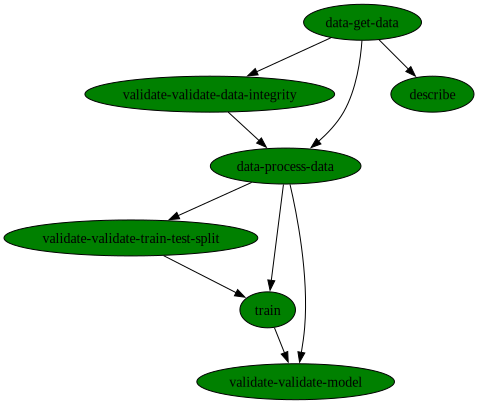

uid,start,state,name,parameters,results
...27bc6a,Nov 20 23:24:07,completed,validate-validate-model,model_path=store://artifacts/cicd-flow/model:ff407bae-3a79-437b-8cac-4bf2992565c8label_column=targetallow_validation_failure=True,passed_suite=False
...462f0a,Nov 20 23:22:02,completed,train,label_column=target,best_iteration=2accuracy=0.896551724137931f1_score=0.888888888888889precision_score=0.8recall_score=1.0
...6afa9a,Nov 20 23:20:50,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...6b873d,Nov 20 23:20:00,completed,data-process-data,"label_column=targettest_size=0.1ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...297578,Nov 20 23:19:07,completed,describe,label_column=target,
...233160,Nov 20 23:19:06,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...566dd4,Nov 20 23:18:17,completed,data-get-data,,


In [4]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [7]:
# config.challenger_model_tag = "latest"
deploy_config = config.get_workflow_config(workflow_name="deploy")
deploy_config

{'challenger_model_tag': 'challenger',
 'champion_model_tag': 'champion',
 'label_column': 'target',
 'deploy_model_name': 'model'}

In [8]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

> 2023-11-20 15:27:09,660 [warning] WARNING!, you seem to have uncommitted git changes, use .push()


IndexError: list index out of range

### Invoke Model

In [7]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]
# data
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


> 2023-09-21 15:21:36,012 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': 'b475e581-8f43-4490-8003-52bf8c537e20',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [ ]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(data)
    serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

In [12]:
import mlrun

project = mlrun.get_or_create_project("default")


> 2023-11-20 10:52:01,911 [info] Project loaded successfully: {'project_name': 'default'}


In [13]:

%%writefile test.py
def handler():
    print("AAA")


Writing test.py


In [16]:

fn = project.set_function(name="test", func="test.py", image="mlrun/mlrun", kind="job", handler="handler")


In [20]:

project.build_function(fn ,requirements=["pandas==1.5.0"])


> 2023-11-20 10:55:28,027 [info] Started building image: .mlrun/func-default-test:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:1.4.1  
INFO[0000] Retrieving image mlrun/mlrun:1.4.1 from registry index.docker.io 
INFO[0001] Built cross stage deps: map[]                
INFO[0001] Retrieving image manifest mlrun/mlrun:1.4.1  
INFO[0001] Returning cached image manifest              
INFO[0001] Executing 0 build triggers                   
INFO[0001] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0023] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt 
INFO[0023] Taking snapshot of full filesystem...        
INFO[0029] cmd: /bin/sh                                 
INFO[0029] args: [-c echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt] 
INFO[0029] Running: [/bin/sh -c echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt] 
Installing /e

BuildStatus(ready=True, outputs={'image': '.mlrun/func-default-test:latest'})

In [21]:

project.run_function(fn)

> 2023-11-20 10:59:14,805 [info] Storing function: {'name': 'test-handler', 'uid': '1059ed8adab842e4a9926edfa2d9351e', 'db': 'http://localhost:30070'}
> 2023-11-20 10:59:15,047 [info] Job is running in the background, pod: test-handler-dpbw8
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
AAA
> 2023-11-20 18:59:34,259 [info] Run execution finished: {'status': 'completed', 'name': 'test-handler'}
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...d9351e,0,Nov 20 18:59:33,completed,test-handler,kind=jobowner=Nick_Schenonemlrun/client_version=1.4.1mlrun/client_python_version=3.9.18host=test-handler-dpbw8,,,,


> 2023-11-20 10:59:43,761 [info] Run execution finished: {'status': 'completed', 'name': 'test-handler'}
